https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html 

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Generate some data
from sklearn.datasets.samples_generator import make_blobs
X, y_true = make_blobs(n_samples=400, centers=4,
                       cluster_std=0.60, random_state=0)
X = X[:, ::-1] # flip axes for better plotting

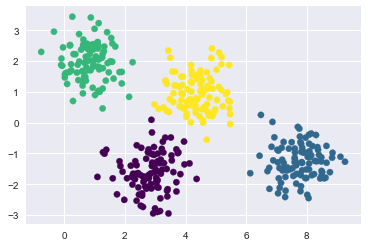

In [3]:
# Plot the data with K Means Labels
from sklearn.cluster import KMeans
kmeans = KMeans(4, random_state=0)
labels = kmeans.fit(X).predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [4]:
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist

def plot_kmeans(kmeans, X, n_clusters=4, rseed=0, ax=None):
    labels = kmeans.fit_predict(X)

    # plot the input data
    ax = ax or plt.gca()
    ax.axis('equal')
    ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)

    # plot the representation of the KMeans model
    centers = kmeans.cluster_centers_
    radii = [cdist(X[labels == i], [center]).max()
             for i, center in enumerate(centers)]
    for c, r in zip(centers, radii):
        ax.add_patch(plt.Circle(c, r, fc='#CCCCCC', lw=3, alpha=0.5, zorder=1))

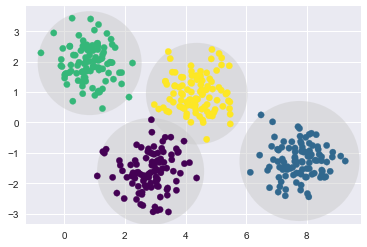

In [5]:
kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X)

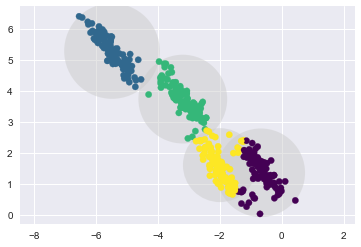

In [6]:
rng = np.random.RandomState(13)
X_stretched = np.dot(X, rng.randn(2, 2))

kmeans = KMeans(n_clusters=4, random_state=0)
plot_kmeans(kmeans, X_stretched)

In [10]:
data = pd.read_csv('datasets/train/toy.csv', header=None)
data = data.values

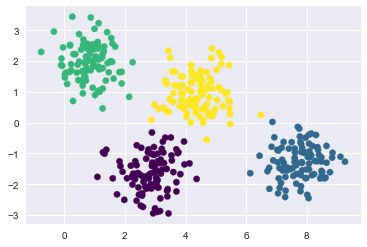

In [14]:
from sklearn.mixture import GMM
gmm = GMM(n_components=4).fit(X)
labels = gmm.predict(X)
plt.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis');

In [17]:
probs = gmm.predict_proba(X)
print(probs[:5].round(3))

[[0.    0.475 0.    0.525]
 [1.    0.    0.    0.   ]
 [1.    0.    0.    0.   ]
 [0.    0.    0.    1.   ]
 [1.    0.    0.    0.   ]]


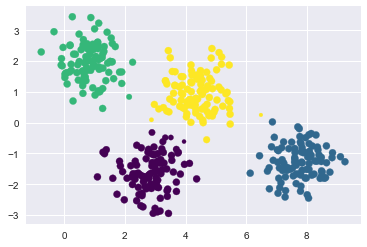

In [18]:
size = 50 * probs.max(1) ** 2  # square emphasizes differences
plt.scatter(X[:, 0], X[:, 1], c=labels, cmap='viridis', s=size);

In [19]:
from matplotlib.patches import Ellipse

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covars_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

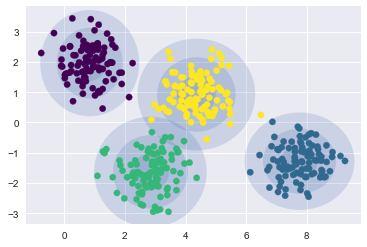

In [64]:
gmm = GMM(n_components=4, random_state=42)
plot_gmm(gmm, X)
probs = gmm.predict_proba(X)

In [67]:
X.shape

(400, 2)

In [31]:
probs.shape

(400, 4)

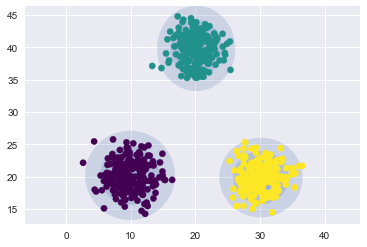

In [98]:
gmm2 = GMM(n_components=3, random_state=42)
plot_gmm(gmm2, data)

In [40]:
x = np.arange(
    round(min(data[:, 0])) - 10,
    round(max(data[:, 0])) + 10, 0.1)
y = np.arange(
    round(min(data[:, 1])) - 10,
    round(max(data[:, 1])) + 10, 0.1)
xx, yy = np.meshgrid(x, y, sparse=True)

a = xx + yy - yy
b = xx + yy - xx
mem = np.concatenate([
    a.reshape([a.shape[0], a.shape[1], 1]),
    b.reshape([a.shape[0], a.shape[1], 1])
],
                     axis=2)

# z = D(torch.from_numpy(mem).float()).data.numpy()
# plt.plot(data[:, 0], data[:, 1], '.b', label='Real')
# h = plt.contourf(x,
#                  y,
#                  z.reshape(z.shape[0], z.shape[1]),
#                  20,
#                  cmap='Spectral')
# plt.colorbar()
# plt.show()

In [68]:
gmm2 = GMM(n_components=3, random_state=42)
plot_gmm(gmm2, data)

In [77]:
pred = np.zeros([mem.shape[0],mem.shape[1]])
for i in range(mem.shape[0]):
    for j in range(mem.shape[1]):
        pred[i,j]=np.max(gmm2.predict_proba(mem[i,j,:].reshape([1,-1])),axis=1)

In [96]:
examp = np.array([20,30])
examp.shape

(2,)

In [102]:

gmm2.predict_proba(examp.reshape([1,-1]))

array([[1.48916423e-04, 9.99849514e-01, 1.56921803e-06]])

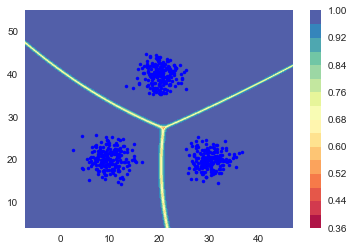

In [78]:
plt.plot(data[:, 0], data[:, 1], '.b', label='Real')
h = plt.contourf(x,
                 y,
                 pred,
                 20,
                 cmap='Spectral')
plt.colorbar()
plt.show()

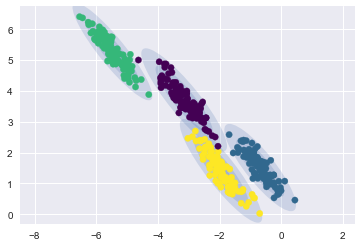

In [23]:
gmm = GMM(n_components=4, covariance_type='full', random_state=42)
plot_gmm(gmm, X_stretched)

---

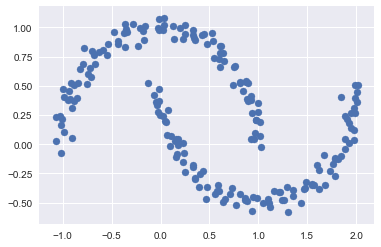

In [24]:
from sklearn.datasets import make_moons
Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

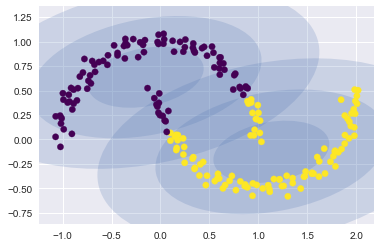

In [25]:
gmm2 = GMM(n_components=2, covariance_type='full', random_state=0)
plot_gmm(gmm2, Xmoon)

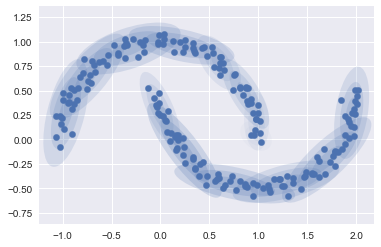

In [26]:
gmm16 = GMM(n_components=16, covariance_type='full', random_state=0)
plot_gmm(gmm16, Xmoon, label=False)

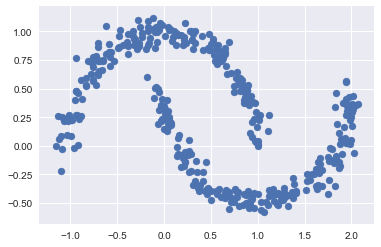

In [27]:
Xnew = gmm16.sample(400, random_state=42)
plt.scatter(Xnew[:, 0], Xnew[:, 1]);